In [25]:
import pandas as pd
import geopandas as gpd
# data file from here: https://www.census.gov/geographies/reference-files/time-series/demo/metro-micro/delineation-files.html
df = pd.read_csv('2020_CBSA.csv', dtype={'FIPS County Code': str})
import contextily as cx
import matplotlib.pyplot as plt

In [26]:
state_codes = {
    'WA': '53', 'DE': '10', 'DC': '11', 'WI': '55', 'WV': '54', 'HI': '15',
    'FL': '12', 'WY': '56', 'PR': '72', 'NJ': '34', 'NM': '35', 'TX': '48',
    'LA': '22', 'NC': '37', 'ND': '38', 'NE': '31', 'TN': '47', 'NY': '36',
    'PA': '42', 'AK': '02', 'NV': '32', 'NH': '33', 'VA': '51', 'CO': '08',
    'CA': '06', 'AL': '01', 'AR': '05', 'VT': '50', 'IL': '17', 'GA': '13',
    'IN': '18', 'IA': '19', 'MA': '25', 'AZ': '04', 'ID': '16', 'CT': '09',
    'ME': '23', 'MD': '24', 'OK': '40', 'OH': '39', 'UT': '49', 'MO': '29',
    'MN': '27', 'MI': '26', 'RI': '44', 'KS': '20', 'MT': '30', 'MS': '28',
    'SC': '45', 'KY': '21', 'OR': '41', 'SD': '46'
}
codes = dict(zip(state_codes.values(), state_codes.keys()))

In [27]:
# url = 'https://www2.census.gov/programs-surveys/popest/datasets/2020-2021/metro/totals/cbsa-est2021-alldata.csv'
# df = pd.read_csv(url)

Text(0.5, 1.0, 'NYC Metropolitan Statistical Area')

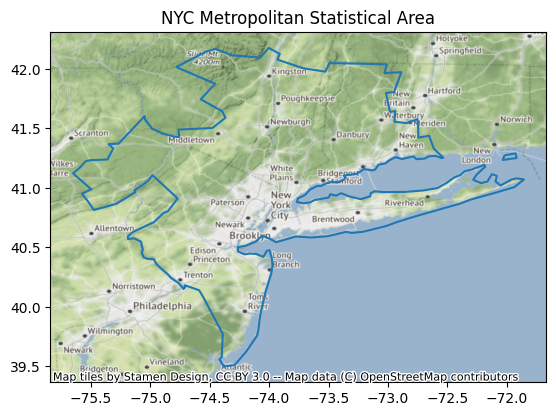

In [28]:
# The target area
t = gpd.read_file('https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_csa_20m.zip')
ax = t[t.CSAFP == '408'].boundary.plot()
cx.add_basemap(ax, crs=t.crs.to_string())
plt.title('NYC Metropolitan Statistical Area')

In [29]:
df.columns = df.iloc[1].values#
df.drop(index=[0,1], inplace=True)

In [30]:
nyc = df.loc[df['CSA Code'] == '408']

In [31]:
from helper_funcs import *
# createDir('NYC_metro_boundaries')

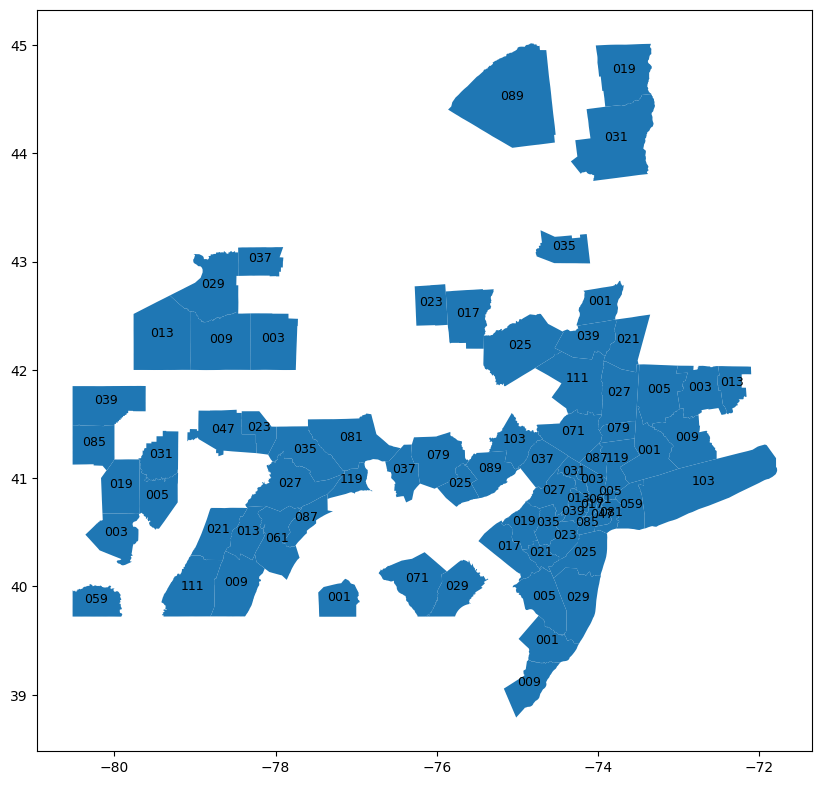

In [32]:
counties = gpd.read_file('https://www2.census.gov/geo/tiger/TIGER2020/COUNTY/tl_2020_us_county.zip')
fig, ax = plt.subplots(1, 1, figsize=(10, 20))
nyc_counties = counties.loc[(counties.STATEFP.isin(nyc['FIPS State Code'])) & (counties.COUNTYFP.isin(nyc['FIPS County Code']))]
nyc_counties.plot(ax=ax)
for idx, row in nyc_counties.iterrows():
#     print(row['geometry'].centroid.x)
    plt.annotate(text=row['COUNTYFP'], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                 horizontalalignment='center', fontsize=9)


In [59]:
selected = t[t.CSAFP == '408']
selected = selected.reset_index()#.reindex()
selected['index'] = 0
selected = selected.set_index('index')
def func(x):
    temp = gpd.GeoDataFrame([x])
    temp.set_geometry('geometry')
    temp.set_crs(st_tract.crs, inplace=True)
    
    temp.reset_index(inplace=True)#.reindex()
    temp['index'] = 0
    temp = temp.set_index('index')

    return temp.within(selected)

st_tract['keep'] = st_tract.apply(lambda x: func(x), axis=1)

In [61]:
metro_areas = pd.DataFrame()
for state_cd in nyc['FIPS State Code'].unique():
    st_tract = gpd.read_file(f"https://www2.census.gov/geo/tiger/TIGER2020/TRACT/tl_2020_{state_cd}_tract.zip")
    st_tract.COUNTYFP = st_tract.COUNTYFP.astype(str)
    
    st_tract['keep'] = st_tract.apply(lambda x: func(x), axis=1)
    
    filtered = st_tract[st_tract['keep']]
    
#     filtered = st_tract.loc[st_tract.COUNTYFP.isin(nyc['FIPS County Code'])]
    
    metro_areas = pd.concat([metro_areas, filtered])
metro_areas['state_abbr'] = metro_areas.STATEFP.map(codes)

In [62]:
metro_areas.shape

(5504, 15)

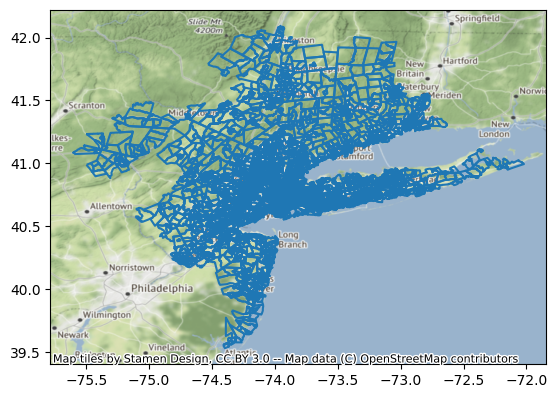

In [63]:
ax = metro_areas.boundary.plot()
cx.add_basemap(ax, crs=metro_areas.crs.to_string())

In [67]:
metro_areas.to_file('nyc_metro_boundaries/nyc_metro_boundaries.shp')

In [65]:
metro_areas['GEOID'].nunique()

5504

In [66]:
metro_areas['GEOID'].nunique()

5504